In [1]:
# Bioinformatics
from pysam import VariantFile

# Data Analysis
import pandas as pd
import numpy as np
import math

import os

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

mpl.rcParams['figure.dpi'] = 300

## Functions to read and store VCF

In [2]:
def read_vcf(vcf, sample) :

    dc = {"CHROM":[], "POS":[], "ALS":[], "QUAL":[], "AAD":[], "ADP":[],
          "OAD":[], "ODP":[], "ATP":[], "OTP":[], "AAF":[], "OAF":[], "GET":[], "SH":[]}

    vcf_in = VariantFile(vcf)
    vcf_in.subset_samples(["ancestor", sample])

    for n, rec in enumerate(vcf_in) :
        if n % 10000000 == 0 :
            print("Elapsed records: {}".format(n))
        dc["CHROM"].append(rec.chrom)
        dc["POS"].append(rec.pos)
        dc["ALS"].append(rec.alleles)
        dc["QUAL"].append(rec.qual)
        dc["SH"].append(rec.samples[sample]["SH"])
        dc["GET"].append(rec.samples[sample]["GET"])

        try :
            aad = rec.samples["ancestor"]["AD"]
        except :
            aad = 0
        try : 
            adp = rec.samples["ancestor"]["DP"]
        except :
            adp = 0
        try :
            aaf = float(min(aad)/adp)
        except :
            aaf = None

        dc["AAD"].append(aad)
        dc["ADP"].append(adp)
        dc["AAF"].append(aaf)
        dc["ATP"].append(rec.samples["ancestor"]["TP"])

        try :
            oad = rec.samples[sample]["AD"]
        except :
            oad = 0
        try :
            odp = rec.samples[sample]["DP"]
        except :
            odp = 0
        try :
            oaf = float(min(oad)/odp)
        except :
            oaf = None
        dc["OAD"].append(oad)
        dc["ODP"].append(odp)
        dc["OAF"].append(oaf)
        dc["OTP"].append(rec.samples[sample]["TP"])
    
    # Prepare datatypes
    dc_types = {"CHROM":"category", "POS":"Int32", "QUAL":"Float32", "ALS":"object", "GET":"category", "SH":"Int8",
            "AAD":"object", "ADP":"Int16","AAF":"Float32", "ATP":"category",
            "OAD":"object", "ODP":"Int16", "OAF":"Float32", "OTP":"category",
           }
    
    loh = {"CHROM":[], "START":[], "END":[], "SIZE":[], "MEAN_SHARED":[]}

    df = pd.DataFrame.from_dict(dc) #, dtype=dc_types)
    df = df.astype(dc_types, copy=False)
    
    return df

## Functions to get clusters & probabilities

In [3]:
def expected_LOH_clusters(proba_of_loh, original_heterozygosity, N=100000000) :
    # proba of loh : float 0.0 <= n <= 1.0
    # original_heterozygosity : int
    # N = simulated vector size
    simu_array = np.random.binomial(1, proba_of_loh, N) # Random array following a binomial
    split_array = np.split(simu_array, np.argwhere(np.diff(simu_array) != 0)[:,0] + 1) # Split by identical contiguous values
    lengths = [] # 3. Transform each element in array to its length
    # For each sub array of contiguous 0 (conserved) or contiguous 1 (loss)
    for sub in split_array :
        if sub[0] == 1 : # If first element of subarray is 1 --> store its length in the lengths list
            lengths.append(len(sub))
    lengths = np.array(lengths) # create an array storing all lengths
    sizes, freq = np.unique(lengths, return_counts = True) # Count the frequency of each length in the array
    # Create a dictionary with (key) length : frequency (value)
    dE = {}
    for x, y in zip(sizes, freq) :
        dE[x] = y
    
    # For each size in simulated array : add 0 if size does not exist --> should not happen
    for x in range(1, max(sizes)) :
        if x not in sizes :
            dE[x] = 0
    
    #print(dE)
    # Compute the probability of an event to occur given a number of heterozygous sites (p = frequency / N)
    expected_proba_size = {k : v/N for k, v in dE.items()}
    # Given all sizes probability compute the expected frequency given the original number of heterozygous sites considered
    expected_freq_of_size_in_original_heterozygosity = {k : math.ceil(p*original_heterozygosity) for k, p in expected_proba_size.items()}    
    
    """
    for k, v in expected_freq_of_size_in_original_heterozygosity.items() :
        print(k, v)
    """
    
    return expected_freq_of_size_in_original_heterozygosity
    
def observed_LOH_clusters(df) :
    # This function returns a dataframe containing all LOH clusters found according to the criterions stated above.
    # This function also returns a dictionary with the global probability of LOH and per chromosome probability of LOH
    # It comes with a bunch of other informations such as :
    # - min, mean and max coverage found in the cluster --> relevant for plotting expected cluster sizes --> some of them may be containing breakpoints and thus be unreliable
    
    aggregate_dict = {"CHROM": "first", "POS":["first","last"], "ADP":["min", "max", "mean"],
                     "ODP": ["min", "max", "mean"], "GET":["first", "size"], "SH":["min", "max", "mean"]}
    c = df.loc[df["GET"].isin(["L", "C", "S", "M", "S4"])] # 1. Remove 0, U, R, A, S1, S3 and Ns

    chrs = []
    for chrom in c["CHROM"].unique() :
        chr_only = c.query("CHROM == @chrom")
        gbc = chr_only.groupby([(chr_only["GET"] != chr_only["GET"].shift()).cumsum()]).agg(aggregate_dict)
        chrs.append(gbc)

    return pd.concat(chrs)


def get_num_varsite(df, chrom=None, mincov=None, maxcov=None) :
    # This function returns the number of heterozygous sites to consider
    d = df.copy()
    if chrom != None :
        d = d.loc[d["CHROM"] == chrom]
    if mincov == None or maxcov == None :
        return len(d.loc[d["ATP"].isin(["BS", "BI", "MI", "MS", "MO"])])
    elif mincov == None and maxcov != None :
        return len(d.loc[(d["ADP"] <= maxcov) & (d["ATP"].isin(["BS", "BI", "MI", "MS", "MO"]))])
    elif mincov != None and maxcov == None :
        return len(d.loc[(d["ADP"] >= mincov) & (d["ATP"].isin(["BS", "BI", "MI", "MS", "MO"]))])
    elif mincov != None and maxcov != None :
        return len(d.loc[(d["ADP"] >= mincov) & (d["ADP"] <= maxcov) & (d["ATP"].isin(["BS", "BI", "MI", "MS", "MO"]))])

def get_num_LOH(clusters, chrom=None, mincov_ANC=None, maxcov_ANC=None, mincov_OF=None, maxcov_OF=None) :
    # This function returns the number of heterozygous sites to consider
    d = clusters.copy()
    d = d.loc[d["GET", "first"] == "L"]
    if chrom != None :
        d = d.loc[d["CHROM", "first"] == chrom]
    if mincov_ANC != None :
        d = d.loc[d["ADP", "min"] >= mincov_ANC]
    if mincov_OF != None :
        d = d.loc[d["ODP", "min"] >= mincov_OF]
    if maxcov_ANC != None :
        d = d.loc[d["ADP", "min"] <= maxcov_ANC]
    if maxcov_OF != None :
        d = d.loc[d["ODP", "min"] <= maxcov_OF]
        
    return d["GET", "size"].sum()

## Functions to obtain plots

In [4]:
def plot_clusters_and_model(df, clusters, sample, condition) :
    # GLOBAL
    numvar = get_num_varsite(df)
    numlost = get_num_LOH(clusters)
    print("Numvar:", numvar, "Numlost:", numlost)
    proba_loss = numlost/numvar
    print("Probability of LOH: p(L) = {}".format(proba_loss))

    simev = expected_LOH_clusters(proba_loss, numvar)
    print("Simulated: {}".format(simev))
    
    # PLOT
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    fig, ax = plt.subplots(figsize=(10,5))

    size, freq = np.unique(clusters.loc[clusters["GET", "first"] == "L"]["GET", "size"], return_counts=True)
    ax.plot(size, freq, linewidth=0.7, color="k", marker="o", mfc=colors[0], alpha=0.8, linestyle="-", zorder=10, label="Observed")
    size, freq = np.unique(clusters.loc[(clusters["GET", "first"] == "L") & (clusters["SH", "mean"] <= 1.5)]["GET", "size"], return_counts=True)
    ax.plot(size, freq, linewidth=0.7, color="k", marker="o", mfc=colors[1], alpha=0.8, linestyle="-", zorder=10, label="Mean shared <= 1.5")
    size, freq = np.unique(clusters.loc[(clusters["GET", "first"] == "L") & (clusters["SH", "mean"] <= 3.5)]["GET", "size"], return_counts=True)
    ax.plot(size, freq, linewidth=0.7, color="k", marker="o", mfc=colors[2], alpha=0.8, linestyle="-", zorder=10, label="Mean shared <= 3.5")

    simsize = []
    simfreq = []
    for k, v in simev.items() :
        if v != 0 :
            simsize.append(k)
            simfreq.append(v)

    ax.plot(simsize, simfreq, linewidth=0.7, color="k", marker="s", mfc=colors[3], linestyle="-", zorder=10, label="Simulation")

    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.xaxis.set_tick_params(labelsize=13)
    ax.yaxis.set_tick_params(labelsize=13)
    ax.set_ylabel("Count", fontsize=14)
    ax.set_xlabel("Cluster size", fontsize=14)
    ax.set_facecolor('whitesmoke')
    ax.yaxis.grid(True, zorder=1)
    ax.set_xticks([1,10,100,1000,10000])
    ax.set_xticklabels([1,10,100,1000,10000])

    ax.set_xlim(0.8, 20000)

    ax.set_title("LOH clusters size frequency - {} - {}".format(sample, condition), fontsize=14)

    ax.legend(fontsize=12)

    ax.text(x=500, y=12, s="p(L) = {}\nN(var) = {}".format(round(proba_loss,3), numvar), ha="left", fontsize=12)

    plt.show()

# Samples information

In [5]:
all_samples = {
    "D2A1":"Desiccated",
    "D2B3":"Desiccated",
    "D2C1":"Desiccated",
    "D2C3":"Desiccated",
    "D3A1":"Desiccated",
    "D3A3":"Desiccated",
    "D4A3":"Desiccated",
    "D4B4":"Desiccated",
    "D5B3":"Desiccated",
    "D5C1":"Desiccated",
    "D5C3":"Desiccated",
    "D2A1":"Desiccated",
    "H2A3":"Hydrated",
    "H2B4":"Hydrated",
    "H2C3":"Hydrated",
    "H3A4":"Hydrated",
    "H3C4":"Hydrated",
    "H4A4":"Hydrated",
    "H4C2":"Hydrated",
    "H5A2":"Hydrated",
    "H5A3":"Hydrated",
    "H5A4":"Hydrated",
    "H5C2":"Hydrated",
}

# Read samples and get clusters

In [6]:
def read_save_and_plot_sample(vcf, sample, condition) :
    df = read_vcf(vcf, sample)
    clusters = observed_LOH_clusters(df)
    clusters.to_pickle("{}.clusters.LOH.pkl.bz2".format(sample), compression="bz2")
    plot_clusters_and_model(df, clusters, sample, condition)

In [7]:
vcf = "/media/urbe/MyBDrive1/Antoine/27-10-21_VariantCalling_MA/endpoint/merged_allsites.GETS.vcf"

In [ ]:
for sample, condition in all_samples.items() :
    print(sample)
    read_save_and_plot_sample(vcf, sample, condition)
    print("==============\n\n")

# Plot single sample

In [6]:
def get_size_freqs(df, clusters, sample) :
    # GLOBAL
    numvar = get_num_varsite(df)
    numlost = get_num_LOH(clusters)
    print("Numvar:", numvar, "Numlost:", numlost)
    proba_loss = numlost/numvar
    print("Probability of LOH: p(L) = {}".format(proba_loss))

    simev = expected_LOH_clusters(proba_loss, numvar)
    print("Simulated: {}".format(simev))
    
    size, freq = np.unique(clusters.loc[(clusters["GET", "first"] == "L") & (clusters["SH", "mean"] <= 1.5)]["GET", "size"], return_counts=True)
    
    simsize = []
    simfreq = []
    for k, v in simev.items() :
        if v != 0 :
            simsize.append(k)
            simfreq.append(v)

    return size, freq, simsize, simfreq

In [37]:
def plot_sample(size, freq, simsize, simfreq, p, N) :
    # PLOT
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    fig, ax = plt.subplots(figsize=(10,5))

    ax.plot(size, freq, lw=0.7, color="k", marker="o", mfc=colors[0]+"80", mew=0.5, alpha=0.8, linestyle="-", zorder=10, label="Observed")

    ax.plot(simsize, simfreq, lw=0.5, color="k", marker="s", mfc=colors[3]+"80", mew=0.5, linestyle="-", zorder=10, label="Simulation")

    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.xaxis.set_tick_params(labelsize=13)
    ax.yaxis.set_tick_params(labelsize=13)
    ax.set_ylabel("Count", fontsize=14)
    ax.set_xlabel("Cluster size (sample {} - {})".format(sample, condition), fontsize=14)
    ax.yaxis.grid(True, zorder=1)
    ax.set_xticks([1, 5, 10,100,1000,10000])
    ax.set_xticklabels([1,5,10,100,1000,10000])
    ax.set_ylim(0.5, 400000)
    
    ax.set_xlim(0.8, 20000)

    #ax.set_title("LOH clusters size frequency - {} - {}".format(sample, condition), fontsize=14)

    ax.legend(fontsize=12, ncols=2)

    ax.text(x=500, y=12, s="p(L) = {}\nN(var) = {}".format(round(p,3), N), ha="left", fontsize=12)

    ax.spines[["top", "right"]].set_visible(False)
    ax.vlines(x=[5], ymin=0.5, ymax=400000, color="k", zorder=1, lw=0.5)
    
    plt.show()

In [7]:
vcf = "/media/urbe/MyBDrive1/Antoine/27-10-21_VariantCalling_MA/endpoint/merged_allsites.GETS.vcf"
sample = "D5C3"
condition = all_samples[sample]
df = read_vcf(vcf, sample)
clusters = observed_LOH_clusters(df)
size, freq, simsize, simfreq = get_size_freqs(df, clusters, sample)

Elapsed records: 0
Elapsed records: 10000000
Elapsed records: 20000000
Elapsed records: 30000000
Elapsed records: 40000000
Elapsed records: 50000000
Elapsed records: 60000000
Elapsed records: 70000000
Elapsed records: 80000000
Elapsed records: 90000000
Elapsed records: 100000000
Numvar: 1954043 Numlost: 234821
Probability of LOH: p(L) = 0.1201718692986797
Simulated: {1: 181813, 2: 21822, 3: 2626, 4: 316, 5: 39, 6: 5, 7: 1, 8: 1, 9: 1}


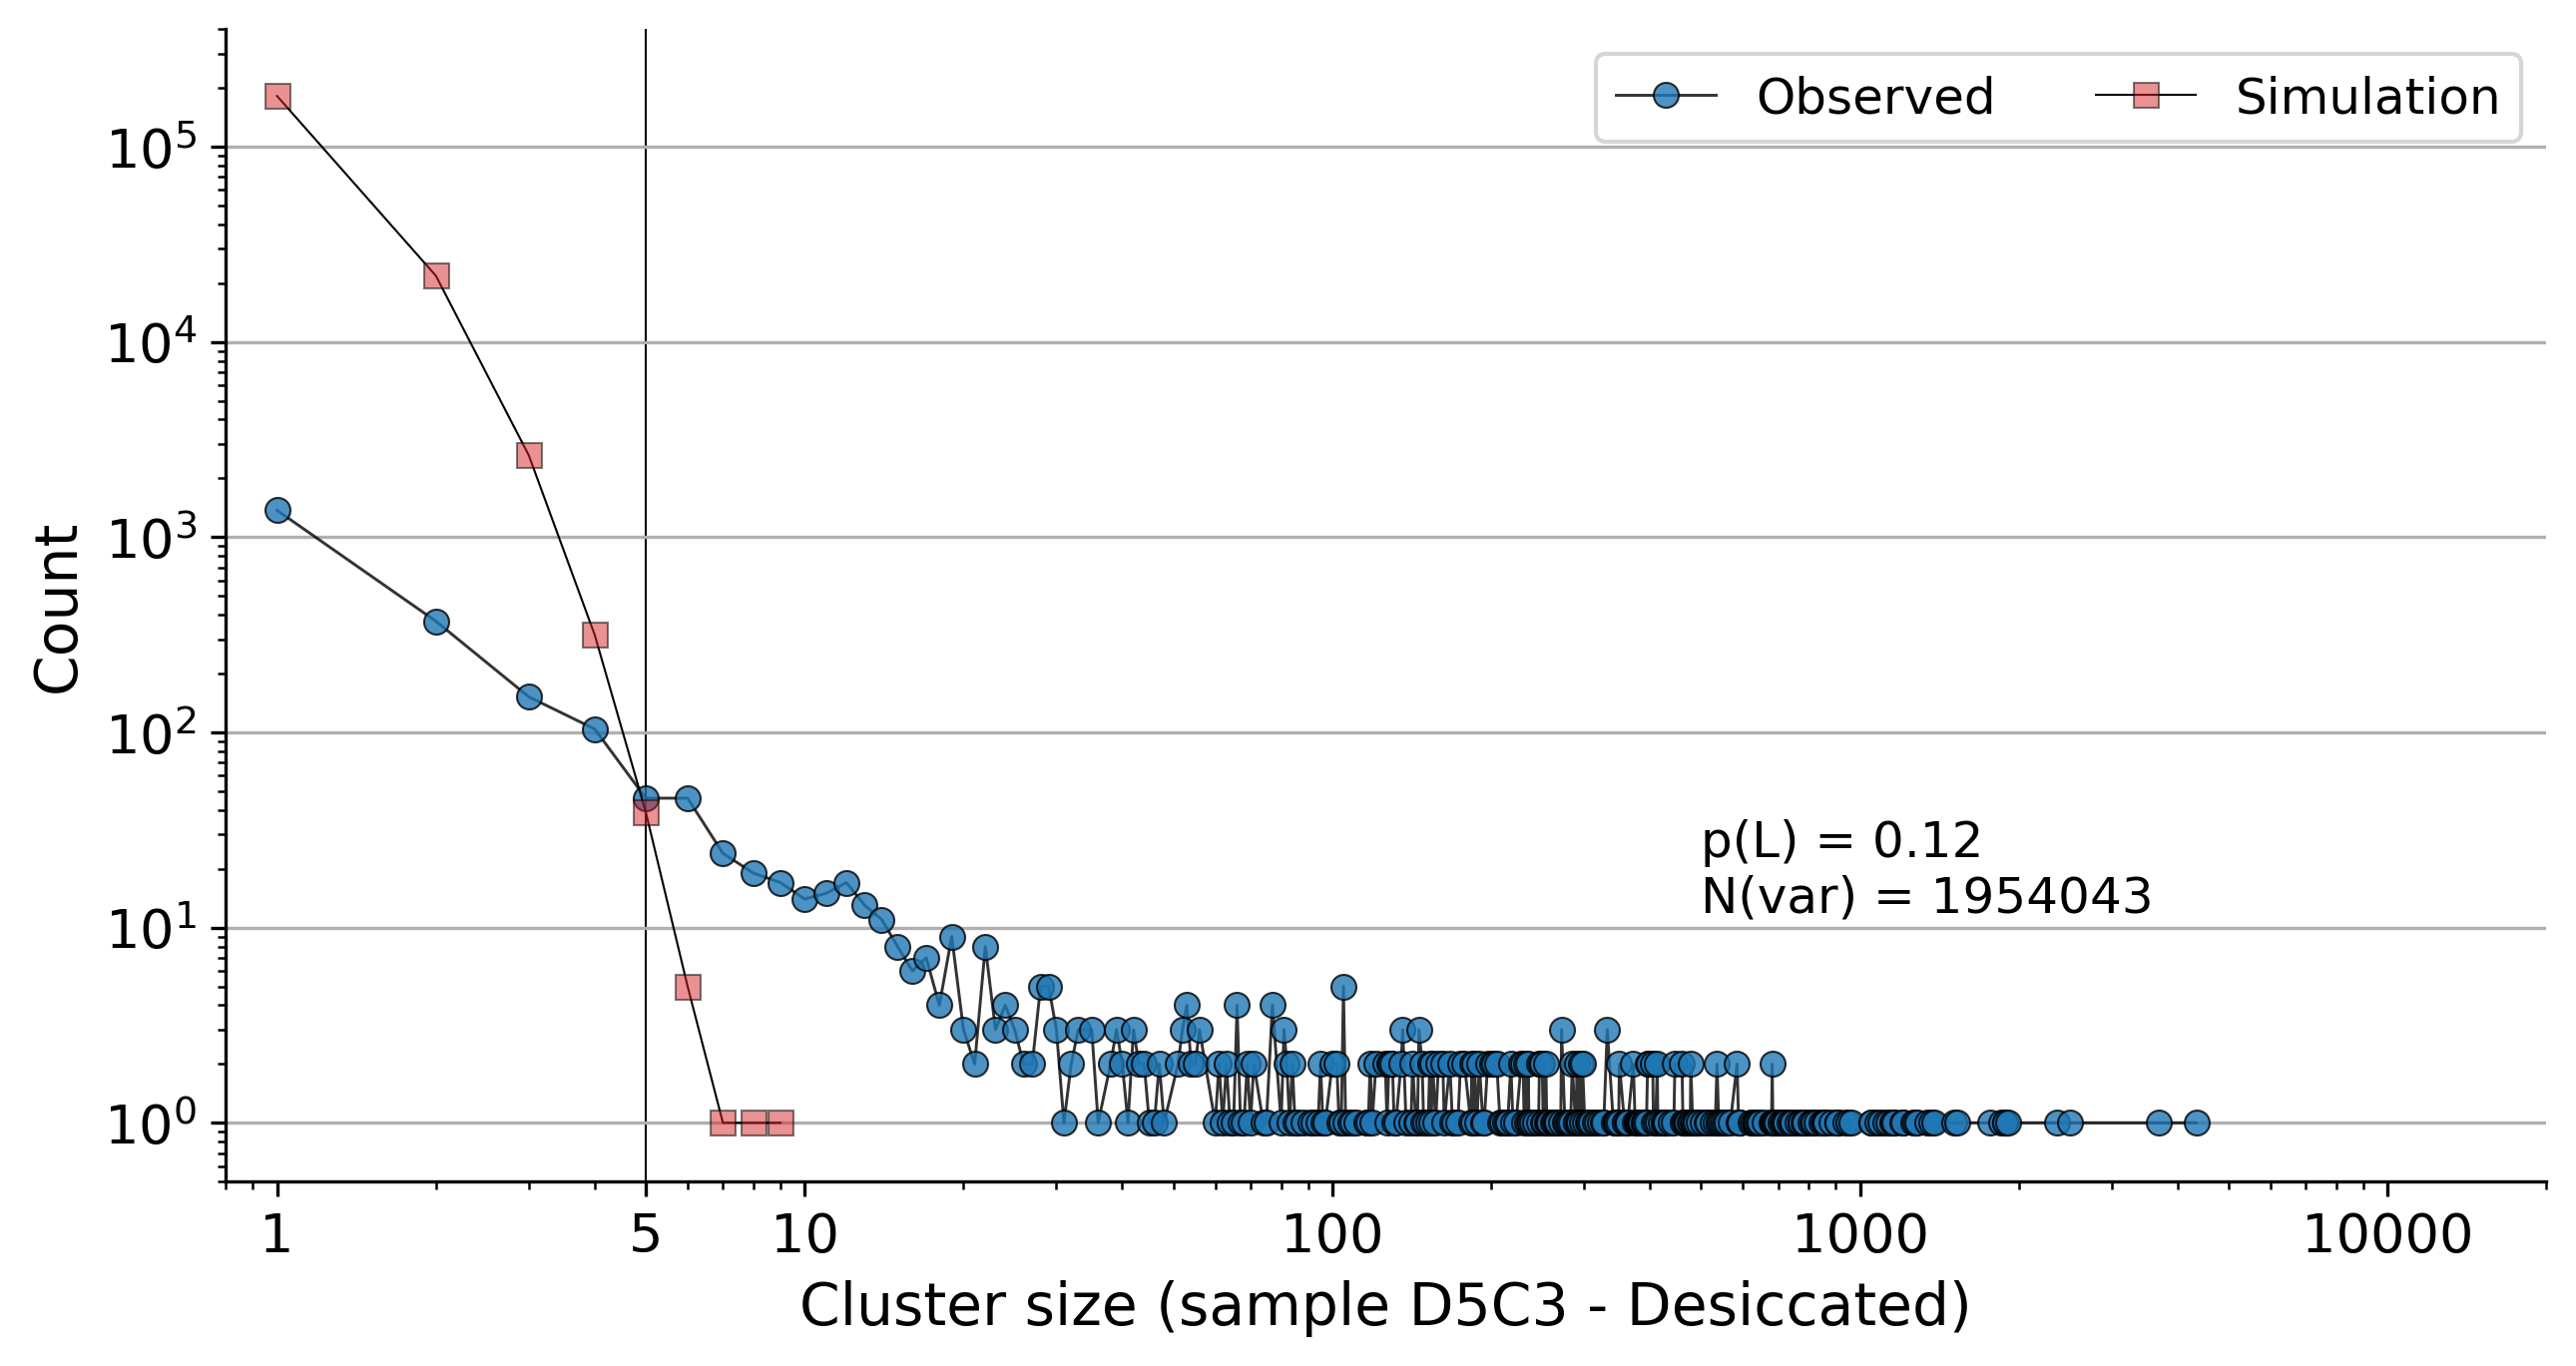

In [38]:
plot_sample(size, freq, simsize, simfreq, p=0.1201718692986797, N=1954043)